# Wprowadzenie

Dla celów tego praktycznego samouczka poświęconego uczeniu się osadzeń grafów wiedzy wykorzystamy bibliotekę otwartoźródłową [AmpliGraph](https://github.com/Accenture/AmpliGraph).

# Instalacja bilioteki 

Zaczniemy od instalacji biblioteki oraz importu innych bibliotek jakich będziemy używać w tym samouczku.

Jeśli korzystasz z Google Collaboratory wystarczy wybrać odpowiednią wersję biblioteki `tensorflow`, jak w poniższej komórce:




In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


Zainstalujmy bibliotekę AmpliGraph:


In [2]:
#!pip install ampligraph

Zaimportujmy teraz potrzebne nam w tym samouczku biblioteki, w tym `tensorflow`:

In [3]:
%tensorflow_version 1.x
import ampligraph
import numpy as np
import pandas as pd
import tensorflow as tf
from ampligraph.datasets import load_fb15k_237
from ampligraph.evaluation import train_test_split_no_unseen, evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.discovery import query_topn, discover_facts, find_clusters
from ampligraph.latent_features import TransE, ComplEx, ConvE
from ampligraph.utils import save_model, restore_model

print('Wersja tensorflow: ', tf.__version__)
print('Wersja AmpliGraph: ', ampligraph.__version__)

Wersja tensorflow:  1.15.2
Wersja AmpliGraph:  1.4.0


# Ładowanie grafu wiedzy i przygotowanie danych do uczenia

Załadujemy jeden z popularnych grafów wiedzy o nazwie Freebase (w wersji Freebase-15k-237).
Ampligraph dostarcza zbiór interfejsów API do ładowania popularnych grafów wiedzy.
Dostarczany jest również zestaw API do wczytywania danych w różnych formatach takich jak: `csv`, `ntriples` i `rdf`.

In [4]:
from ampligraph.datasets import load_fb15k_237


Następnie załadujemy zbiór danych dotyczących domeny filmów (numeryczne ID zostały zamienione na nazwy zrozumiałe dla człowieka). 

In [5]:
import pandas as pd

URL = 'https://ampgraphenc.s3-eu-west-1.amazonaws.com/datasets/freebase-237-merged-and-remapped.csv'
dataset = pd.read_csv(URL, header=None)
dataset.columns = ['subject', 'predicate', 'object']
dataset.head(5)

,subject,predicate,object
0,"queens college, city university of new york",/education/educational_institution/students_gr...,carol leifer
1,digital equipment corporation,/business/business_operation/industry,computer hardware
2,/m/0drtv8,/award/award_ceremony/awards_presented./award/...,laurence mark
3,the departed,/award/award_winning_work/awards_won./award/aw...,leonardo dicaprio
4,marilyn manson,/people/person/profession,actor


Następnie utworzymy zbiory: trenujący, walidacyjny i testowy.
Użyjemy w tym celu funkcji `train_test_split_no_unseen` udostępnianej przez AmpliGraph.
Funkcja ta zapewnia, że w zbiorach walidacyjnym i testowym znajdują się trójki, których encje są "widziane" podczas trenowania.

In [6]:
from ampligraph.evaluation import train_test_split_no_unseen
# pozyskaj zbiór walidacyjny o rozmiarze 500
test_train, X_valid = train_test_split_no_unseen(dataset.values, 500, seed=0)

# pozyskaj zbiór testowy o rozmiarze 1000 z pozostałych trójek
X_train, X_test = train_test_split_no_unseen(test_train, 1000, seed=0)

print('Total triples:', dataset.shape)
print('Size of train:', X_train.shape)
print('Size of valid:', X_valid.shape)
print('Size of test:', X_test.shape)

Total triples: (310079, 3)
Size of train: (308579, 3)
Size of valid: (500, 3)
Size of test: (1000, 3)


# Uczenie modelu

Zaczniemy od utwórzenia modelu TransE i wytrenowania go na zbiorze trenującym przy użyciu funkcji `fit`.

**TransE** jest jednym z modeli osadzeń grafów wiedzy, które zostały zaproponowane jako pierwsze. Ten model niejako wyznaczył platformę dla badań nad osadzeniami grafów wiedzy. Wykorzystuje on prostą algebrę wektorową do oceny trójki. Ma bardzo małą liczbę uczonych parametrów w porównaniu do większości modeli. 

<center>$f = - || s + p - o ||_{n}$</center>

In [7]:
from ampligraph.latent_features import TransE

model = TransE(k=150,                                                             # rozmiar osadzenia
               epochs=100,                                                        # liczba epok
               batches_count= 10,                                                 # liczba serii
               eta=1,                                                             # liczba korupcji do wygenerowania podczas trenowania
               loss='pairwise', loss_params={'margin': 1},                        # typ funkcji straty i jej hiperparametry         
               initializer='xavier', initializer_params={'uniform': False},       # typ inicjalizatora i jego hiperparametry
               regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},   # regularyzator i jego hiperparametry
               optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optymalizator i jego hiperparametry
               seed= 0, verbose=True)

model.fit(X_train)

from ampligraph.utils import save_model, restore_model
save_model(model, 'TransE-small.pkl')

Average TransE Loss:   0.013655: 100%|██████████| 100/100 [02:07<00:00,  1.27s/epoch]


## Obliczanie miar oceny

Dla każdej trójki można obliczyć miarę oceny (`score`): jej wartość jest obliczana dla każdej trójki ze zbioru testowego poprzez zastosowanie funkcji oceny. 

Przyjrzyjmy się, w jaki sposób możemy uzyskać wynik dla interesującej nas trójki i jak go zinterpretować.

In [8]:
test_triple = ['harrison ford', 
               '/film/actor/film./film/performance/film', 
               'star wars']

triple_score = model.predict(test_triple)

print('Triple of interest:\n', test_triple)
print('Triple Score:\n', triple_score)

Triple of interest:
 ['harrison ford', '/film/actor/film./film/performance/film', 'star wars']
Triple Score:
 [-8.307494]


Zastaanówmy się teraz co oznacza ten wynik. Na razie jest to tylko liczba, która wymaga interpretacji. Aby zinterpretować ten wynik, mamy dwie zasadnicze możliwości:

* Możemy stworzyć listę hipotez, które chcemy przetestować, ocenić je, a następnie wybrać n najlepszych hipotez jako stwierdzenia prawdziwe.

* Ponieważ, w odróżnieniu od zadania klasyfikacji, wykonujemy zadanie uczenia się rankingu, to aby zinterpretować wynik, możemy wygenerować korupcje (uszkodzenia) danych i porównać wynik trójki z wynikami 'uszkodzonych' danych, aby zobaczyć, jak dobrze model ocenia testowaną trójkę na ich tle.

Przyjrzyjmy się pierwszej opcji. Stwórzmy listę hipotez i przyznajmy im ocenę.



In [9]:
import numpy as np
list_of_actors = ['salma hayek', 'carrie fisher', 'natalie portman',  'kristen bell',
                  'mark hamill', 'neil patrick harris', 'harrison ford' ]

# ułóż je poziomo, aby utworzyć h, r, t
hypothesis = np.column_stack([list_of_actors, 
                              ['/film/actor/film./film/performance/film'] * len(list_of_actors),
                              ['star wars'] * len(list_of_actors),
                             ])

# oceń hipotezę
triple_scores = model.predict(hypothesis)

# dodaj kolumnę z ocenami
scored_hypothesis = np.column_stack([hypothesis, triple_scores])
# sortuj w porządku malejącym
scored_hypothesis = scored_hypothesis[np.argsort(scored_hypothesis[:, 3])]
scored_hypothesis

array([['natalie portman', '/film/actor/film./film/performance/film',
        'star wars', '-8.299669'],
       ['harrison ford', '/film/actor/film./film/performance/film',
        'star wars', '-8.307494'],
       ['carrie fisher', '/film/actor/film./film/performance/film',
        'star wars', '-8.854933'],
       ['neil patrick harris', '/film/actor/film./film/performance/film',
        'star wars', '-9.213134'],
       ['kristen bell', '/film/actor/film./film/performance/film',
        'star wars', '-9.368978'],
       ['salma hayek', '/film/actor/film./film/performance/film',
        'star wars', '-9.425212'],
       ['mark hamill', '/film/actor/film./film/performance/film',
        'star wars', '-9.455224']], dtype='<U39')

**ranga**: Dla trójki obliczana jest wartość miary poprzez generowanie uszkodzeń, a następnie ich ocenianie i obliczanie rangi (pozycji) dla wyniku jaki uzyska dana trójka względem uszkodzeń.

Poniżej pokażemy w kilku krokach algorytm postępowania w celu obliczenia rangi na zbiorze testowym.



**Oblicz ocenę trójki ze zbioru testowego**

In [10]:
test_triple = ['harrison ford', 
               '/film/actor/film./film/performance/film', 
               'star wars']

triple_score = model.predict(test_triple)

print('Interesująca nas trójka:\n', test_triple)
print('Ocena trójki:\n', triple_score)

Interesująca nas trójka:
 ['harrison ford', '/film/actor/film./film/performance/film', 'star wars']
Ocena trójki:
 [-8.307494]


**Wygeneruj uszkodzenie podmiotu i oblicz rangę**

    sub_corr = <?, r, t>

In [11]:
subj_corr =  np.column_stack([list(model.ent_to_idx.keys()),
                [test_triple[1]] * len(model.ent_to_idx), 
                [test_triple[2]] * len(model.ent_to_idx)])

print('Uszkodzenia podmiotu:\n', subj_corr)
print('\nRozmiar uszkodzeń podmiotu:\n', subj_corr.shape)

Uszkodzenia podmiotu:
 [['/m/011xg5' '/film/actor/film./film/performance/film' 'star wars']
 ['/m/011yd2' '/film/actor/film./film/performance/film' 'star wars']
 ['/m/011yxg' '/film/actor/film./film/performance/film' 'star wars']
 ...
 ['zoology' '/film/actor/film./film/performance/film' 'star wars']
 ['zurich' '/film/actor/film./film/performance/film' 'star wars']
 ['zz top' '/film/actor/film./film/performance/film' 'star wars']]

Rozmiar uszkodzeń podmiotu:
 (14184, 3)


**Oblicz oceną (score) dla uszkodzeń podmiotu**

In [12]:
sub_corr_score = model.predict(subj_corr)

Mająć już ocenę, obliczmy rangę w następujący sposób:

<center>$COUNT ( corruption_{score} >= triple_{score} )$</center>

Znajdziemy pozycję hypothesis_score w sub_corr_score, aby uzyskać sub_rank

In [13]:
sub_rank_worst = np.sum(np.greater_equal(sub_corr_score, triple_score[0])) + 1

print('Przydział najgorszej rangi (aby przełamać remis):', sub_rank_worst)

Przydział najgorszej rangi (aby przełamać remis): 1688


**Wygeneruj uszkodzenia obiektu (dopełnienia) i oblicz rangę**

>    ``` obj_corr = <h, r, ?> ```

In [14]:
obj_corr =  np.column_stack([
                [test_triple[0]] * len(model.ent_to_idx),
                [test_triple[1]] * len(model.ent_to_idx), 
                     list(model.ent_to_idx.keys())])


print('Uszkodzenia dopełnienia trójki:\n', obj_corr)
print('\nRozmiar uszkodzeń dopełnienia trójki:\n', obj_corr.shape)

# Oblicz ocenę dla uszkodzeń dopełnienia 
obj_corr_score = model.predict(obj_corr)

# Znajdź pozycję hypothesis_score w obj_corr_score aby otrzymać obj_rank
obj_rank_worst = np.sum(np.less_equal(triple_score[0], obj_corr_score)) + 1
print('Przydział najgorszej rangi (aby przełamać remis):', obj_rank_worst)

Uszkodzenia dopełnienia trójki:
 [['harrison ford' '/film/actor/film./film/performance/film' '/m/011xg5']
 ['harrison ford' '/film/actor/film./film/performance/film' '/m/011yd2']
 ['harrison ford' '/film/actor/film./film/performance/film' '/m/011yxg']
 ...
 ['harrison ford' '/film/actor/film./film/performance/film' 'zoology']
 ['harrison ford' '/film/actor/film./film/performance/film' 'zurich']
 ['harrison ford' '/film/actor/film./film/performance/film' 'zz top']]

Rozmiar uszkodzeń dopełnienia trójki:
 (14184, 3)
Przydział najgorszej rangi (aby przełamać remis): 799


In [15]:
print('Ranga uszkodzeń podmiotu:', sub_rank_worst)
print('Ranga uszkodzeń dopełnienia', obj_rank_worst)

Ranga uszkodzeń podmiotu: 1688
Ranga uszkodzeń dopełnienia 799


**Obliczanie (niefiltrowanej) rangi przy użyciu API evaluate_performance**

Możemy użyć API [evaluate_performance](https://docs.ampligraph.org/en/latest/generated/ampligraph.evaluation.evaluate_performance.html) aby obliczyć rangi. Domyślnie, API `evaluate_performance` oblicza rangi niefiltrowane, tzn. jeśli w uszkodzeniach są obecne prawdziwe pozytywne przykłady, nie zostaną one usunięte przed rangowaniem. Możemy także zastosować filtrowaną ocenę. 


In [16]:
from ampligraph.evaluation import evaluate_performance 

ranks = evaluate_performance(np.array([test_triple]), 
                             model=model,
                             ranking_strategy='worst')

print('\nRangi:', ranks)

100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


Rangi: [[1688  799]]


W powyższym przykładzie użyliśmy strategii **worst**, która jest najpopularniejsza w literaturze.
Działa ona w następujący sposób.
Załóżmy, że istnieje tylko 10 uszkodzeń i załóżmy, że wszystkie uszkodzenia otrzymują taki sam wynik jak testowa trójka. Wg strategii **worst** (**najgorszej rangi**), trójka ze zbioru testowego otrzymuje rangę 11. Jest to najsurowsze podejście i obniża mrr o duży margines, jeśli jest wiele remisów. 
<center> $rank = COUNT( corruption_{score} \ge hypothesis_{score} )$ + 1</center>


Istnieje także wiele innych strategii obliczania rang, zwłaszcza gdy występują remisy. 

## Zagregowane miary

Gdy mamy już rangi dla wszystkich trójek ze zbioru testowego, możemy obliczyć następujące zbiorcze miary: **MR**, **MRR**, **Hits@N**. Miary te wskazują ogólną jakość modelu na zbiorze testowym. Metryki te pochodzą z domeny wyszukiwania informacji (ang. *information retrieval*) i są zawsze obliczane na zbiorze **prawdziwych stwierdzeń**. Aby zilustrować miary, stwórzmy najpierw mały zbiór testowy składający się z 5 trójek i obliczmy ich rangi.

In [17]:
X_test_small = np.array(
                [['doctorate',
                    '/education/educational_degree/people_with_this_degree./education/education/major_field_of_study',
                    'computer engineering'],

                ['star wars',
                    '/film/film/estimated_budget./measurement_unit/dated_money_value/currency',
                    'united states dollar'],

                ['harry potter and the chamber of secrets',
                    '/film/film/estimated_budget./measurement_unit/dated_money_value/currency',
                    'united states dollar'],

                ['star wars', '/film/film/language', 'english language'],
                ['harrison ford', '/film/actor/film./film/performance/film', 'star wars']])


X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test_small, 
                             model=model, 
                             filter_triples=X_filter, 
                             corrupt_side='s,o')
print(ranks)

100%|██████████| 5/5 [00:00<00:00, 28.81it/s]


[[   8    7]
 [   1    1]
 [  77    1]
 [   1    1]
 [1677  789]]


Przyjrzyjmy się teraz każdej zagregowanej mierze:

- **Mean rank (MR)**, jak sama nazwa wskazuje, jest średnią rang wszystkich trójek. Wartość waha się od 1 (idealny przypadek, gdy wszystkie rangi są równe 1) do liczby uszkodzeń (gdzie wszystkie rangi są ostatnie).

![mr formula](https://user-images.githubusercontent.com/281477/90627586-105d6180-e214-11ea-84d4-c5d3e4b089f4.png)

In [18]:
from ampligraph.evaluation import mr_score
print('MR :', mr_score(ranks))

MR : 256.3


- **Mean reciprocal rank (MRR)**, jest średnią wzajemnych rang wszystkich trójek. Wartość waha się od 0 do 1; wyższa wartość jest lepsza dla modelu.

![mrr formula](https://user-images.githubusercontent.com/281477/90627604-12272500-e214-11ea-9777-5d30b23f0d6f.png)

**Zadanie 1: Zaimportuj z `ampligraph` miarę mrr (`mrr_score`) i oblicz zagregowaną miarę.**

In [19]:
from ampligraph.evaluation import mrr_score
print('MRR =', mrr_score(ranks))

MRR : 0.528270788588898


- **hits@n** to procent obliczonych rang, które są większe (w sensie rankingu) lub równe randze n. Wartość ta waha się od 0 do 1; wyższa wartość jest lepsza dla modelu.

![hits formula](https://user-images.githubusercontent.com/281477/90627565-09365380-e214-11ea-81c8-292a3de016d0.png)

**Zadanie 2: Zaimportuj z `ampligraph` miarę htis@n (`hits_at_n_score`) i oblicz zagregowaną miarę dla n równego 10.**

In [21]:
from ampligraph.evaluation import hits_at_n_score
print('Hits@N =', hits_at_n_score(ranks, n=10))

Hits@N = 0.7


**Pytanie 1: Co się stanie, jeśli dla modelu zaobserwujesz, że na zbiorze testowym wynik MRR wynosi 0,01? Czy jest to dobry model? Odpowiedź uzasadnij.**

To nie będzie dobry model. Średnio wzajemna ranga trójek wynosi 100, czyli po uszkodzeniu, relewantne trójki średnio znajdują się dopiero na 100 miejscu w rankingu!

Miary na całym test-set:

In [22]:
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test, 
                             model=model, 
                             filter_triples=X_filter, 
                             corrupt_side='s,o')
print(ranks)
print('MR :', mr_score(ranks))
print('MRR :', mrr_score(ranks))
print('Hits@N :', hits_at_n_score(ranks, n=10))

100%|██████████| 1000/1000 [00:21<00:00, 45.97it/s]


[[  28 4619]
 [   4    1]
 [  55    1]
 ...
 [ 205  564]
 [ 525  537]
 [ 148    2]]
MR : 953.1985
MRR : 0.13335518758995712
Hits@N : 0.254


Zadanie 3: Przeprowadź powyżej omówioną procedurę dla innego modelu, **DistMult**, tj.:


*   zaimportuj ten model z biblioteki AmpliGraph (`DistMult`)
*   utwórz model  (dokumentację możesz znaleźć tutaj https://docs.ampligraph.org/en/1.4.0/ampligraph.latent_features.html)
* wytrenuj go na zbiorze trenującym przy użyciu `fit`
* oblicz rangi
* oblicz i wyświetl zagregowane miary



In [30]:
from ampligraph.latent_features import DistMult

model = DistMult(k=150,                                                           # rozmiar osadzenia
               epochs=100,                                                        # liczba epok
               batches_count= 10,                                                 # liczba serii
               eta=1,                                                             # liczba korupcji do wygenerowania podczas trenowania
               loss='pairwise', loss_params={'margin': 1},                        # typ funkcji straty i jej hiperparametry         
               initializer='xavier', initializer_params={'uniform': False},       # typ inicjalizatora i jego hiperparametry
               regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},   # regularyzator i jego hiperparametry
               optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optymalizator i jego hiperparametry
               seed= 0, verbose=True)

model.fit(X_train)

Average DistMult Loss:   0.023218: 100%|██████████| 100/100 [02:08<00:00,  1.29s/epoch]


In [32]:
def print_report(X, X_filter):
  ranks = evaluate_performance(X, model=model, filter_triples=X_filter, corrupt_side='s,o')
  print(ranks)
  print('MR =', mr_score(ranks))
  print('MRR =', mrr_score(ranks))
  print('Hits@N =', hits_at_n_score(ranks, n=10))

X_filter = np.concatenate([X_train, X_valid, X_test], 0)
print('Miary dla X_test_small')
print_report(X_test_small, X_filter)
print('Miary dla X_test')
print_report(X_test, X_filter)

Miary dla X_test_small


100%|██████████| 5/5 [00:00<00:00, 30.27it/s]


[[  2  10]
 [  1   1]
 [  2   1]
 [  1   1]
 [384   5]]
MR = 40.8
MRR = 0.6302604166666667
Hits@N = 0.9
Miary dla X_test


100%|██████████| 1000/1000 [00:19<00:00, 50.30it/s]


[[   4  689]
 [  36    1]
 [  83    1]
 ...
 [  47   12]
 [ 699 1047]
 [  91    1]]
MR = 274.5925
MRR = 0.2440309308293629
Hits@N = 0.415


# Odkrywanie wiedzy

Bilioteka Ampligraph udostępnia szereg wysokopoziomowych funkcji ułatwiających odkrywanie wiedzy przy użyciu osadzeń grafów:

***query_topn***: która po podaniu dwóch elementów trójki zwróci top_n wyników wszystkich możliwych uzupełnień uporządkowanych według przewidywanego wyniku.

***discover_facts***: generuje zbiór twierdzeń kandydujących przy użyciu jednej z kilku zdefiniowanych strategii i zwraca trójki, które dobrze radzą sobie z oceną uszkodzeń.

***find_clusters***: wykonuje analizę skupień opartą na powiązaniach (linkach w grafie) na  bazie  osadzeń grafu.

***find_duplicates***: która znajdzie duplikaty encji w grafie na podstawie ich osadzeń.

Zilustrujemy teraz wybrane zadania odkrywania wiedzy.



## Uzupełnianie trójek

Czasami możesz mieć parę relacji i encji (głowa lub ogon), lub tylko dwie encje i chcesz zobaczyć, jakie jest najlepszych n wyników zwróconych przez model, który uzupełnia trójkę. 

``` 
    <głowa, relacja, ?> 
    <głowa, ?, ogon>
    <?, relacja, ogon>
```

Podaj listy ```rels_to_consider`` lub ```ents_to_consider`` aby zwrócić trójki, w których brakujący element jest wypełniony tylko z tej listy. 

In [26]:
from ampligraph.discovery import query_topn

triples, scores = query_topn(model, top_n=10, 
                             head='missy elliott', 
                             relation='/people/person/profession', 
                             tail=None, 
                             ents_to_consider=None, 
                             rels_to_consider=None)

for triple, score in zip(triples, scores):
    print('Score: {} \t {} '.format(score, triple))

Score: 2.7429120540618896 	 ['missy elliott' '/people/person/profession' 'record producer'] 
Score: 2.6835122108459473 	 ['missy elliott' '/people/person/profession' 'singer-songwriter'] 
Score: 2.527945041656494 	 ['missy elliott' '/people/person/profession' 'songwriter'] 
Score: 2.5248219966888428 	 ['missy elliott' '/people/person/profession' 'artist'] 
Score: 2.4272890090942383 	 ['missy elliott' '/people/person/profession' 'disc jockey'] 
Score: 2.2694098949432373 	 ['missy elliott' '/people/person/profession' 'bandleader'] 
Score: 2.1713693141937256 	 ['missy elliott' '/people/person/profession' 'musician'] 
Score: 2.104172468185425 	 ['missy elliott' '/people/person/profession' 'model'] 
Score: 2.0743019580841064 	 ['missy elliott' '/people/person/profession' 'music executive'] 
Score: 1.947041392326355 	 ['missy elliott' '/people/person/profession' 'pianist'] 


In [27]:
triples, scores = query_topn(model, top_n=10, 
                             head='the departed', 
                             relation=None, 
                             tail='/m/086k8', 
                             ents_to_consider=None, 
                             rels_to_consider=None)

for triple, score in zip(triples, scores):
    print('Score: {} \t {} '.format(score, triple))

Score: 3.9116628170013428 	 ['the departed' '/film/film/production_companies' '/m/086k8'] 
Score: 3.2380638122558594 	 ['the departed'
 '/award/award_winning_work/awards_won./award/award_honor/award_winner'
 '/m/086k8'] 
Score: 3.170619249343872 	 ['the departed'
 '/award/award_nominee/award_nominations./award/award_nomination/nominated_for'
 '/m/086k8'] 
Score: 2.924628734588623 	 ['the departed' '/film/film/produced_by' '/m/086k8'] 
Score: 2.6392409801483154 	 ['the departed' '/film/film/written_by' '/m/086k8'] 
Score: 2.421265125274658 	 ['the departed'
 '/film/film_distributor/films_distributed./film/film_film_distributor_relationship/film'
 '/m/086k8'] 
Score: 2.4107003211975098 	 ['the departed' '/film/film/executive_produced_by' '/m/086k8'] 
Score: 2.185378313064575 	 ['the departed' '/film/director/film' '/m/086k8'] 
Score: 2.085455894470215 	 ['the departed'
 '/film/film/personal_appearances./film/personal_film_appearance/person'
 '/m/086k8'] 
Score: 1.8792043924331665 	 ['the

## Grupowanie (analiza skupień)

Kiedy model jest już wytrenowany, możemy wykorzystać jego osadzenia i wykonać kolejne zadania, takie jak grupowanie czy klasyfikacja. Przyjrzymy się jak wykonać grupowanie węzłów. Ampligraph dostarcza API[find_clusters](https://docs.ampligraph.org/en/latest/generated/ampligraph.discovery.find_clusters.html), które pobiera model, pojęcia do grupowania oraz model grupowania (oparty na sklearn). Wykonuje grupowanie i zwraca indeksy grup dla pojęć.

In [28]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans


# Pobierz encje, które chcemy połączyć w grupę. Tutaj używamy wszystkich unikalnych encji
all_entities = np.array(list(set(dataset.values[:, 0]).union(dataset.values[:, 2])))
print('Rozmiar podzbioru używanego do generowania podzbioru:', len(all_entities))

# utwórz model grupowania z  sklearn
kmeans = KMeans(n_clusters=3, n_init=100, max_iter=500)

# wywołaj find_clusters aby dostać przydziały encji do grup
clusters = find_clusters(all_entities, model, kmeans, mode='entity')

Rozmiar podzbioru używanego do generowania podzbioru: 14184


Teraz, gdy mamy już przypisane grupy, zailustrujmy je w przestrzeni 2d. Użyjmy PCA do zredukowania wymiarów osadzenia z k=150 do 2 wymiarów.

  Created wheel for adjustText: filename=adjustText-0.7.3-cp37-none-any.whl size=7097 sha256=77e7df4f27b69c8800ca1f8f7584aa0fac0c4082b9ea83c81a856eae9524d32f
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjustText


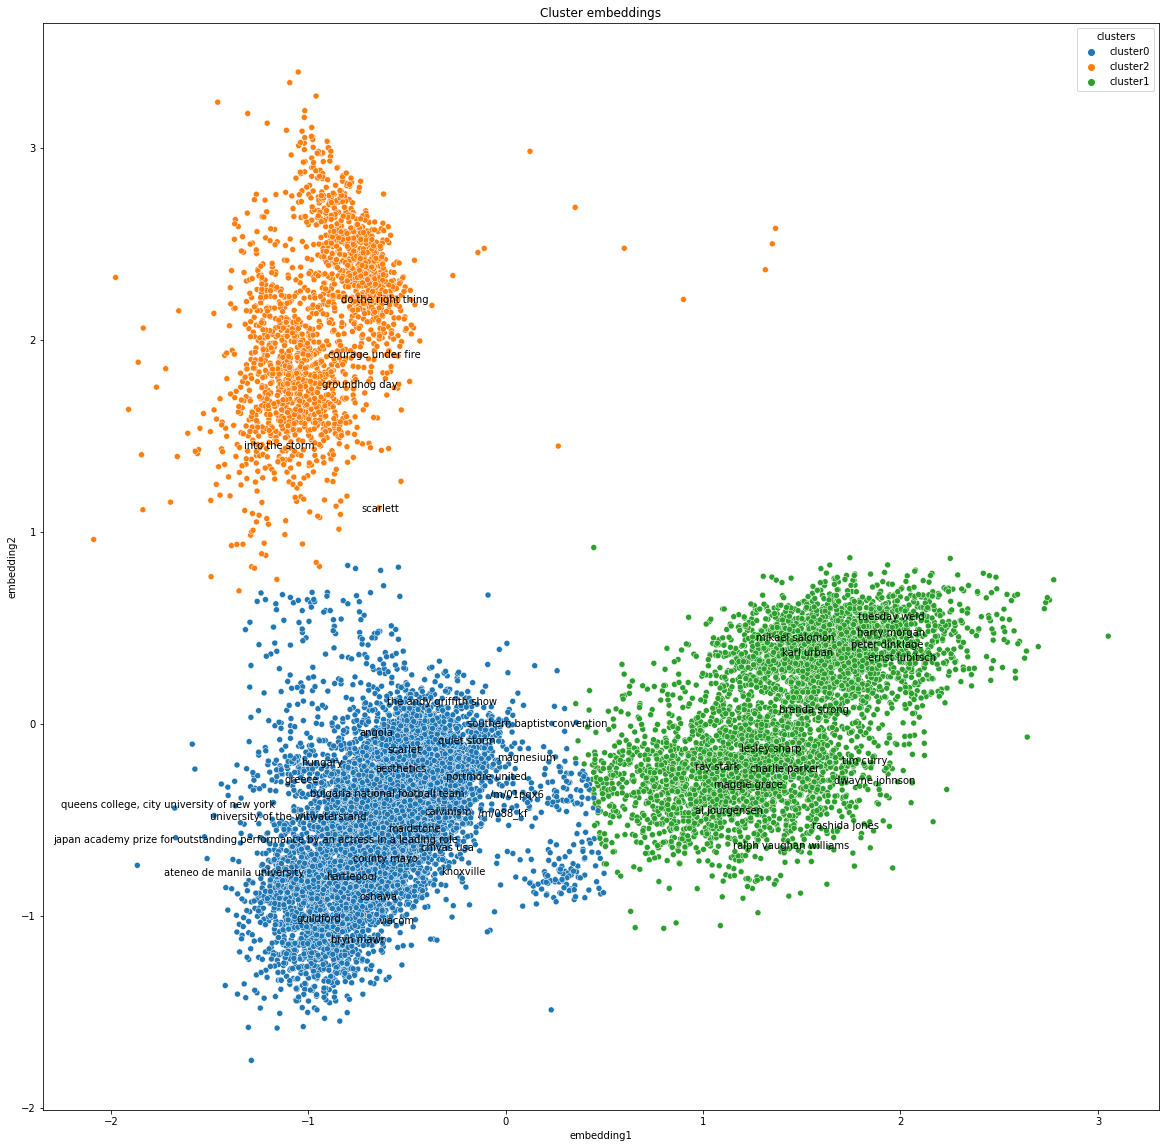

In [29]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Uzyskaj osadzenia (wymiar 150) dla wszystkich interesujących nas encji
jobs_embeddings = model.get_embeddings(all_entities, embedding_type='entity')

# Wykonaj PCA i zredukuj wymiary do 2
embeddings_2d = PCA(n_components=2).fit_transform(np.array([emb for emb in jobs_embeddings]))

# Utwórz ramkę danych, aby wyświetlić wykresy osadzeń przy użyciu funkcji scatterplot
df = pd.DataFrame({"entities": all_entities, "clusters": "cluster" + pd.Series(clusters).astype(str),
                    "embedding1": embeddings_2d[:, 0], "embedding2": embeddings_2d[:, 1]})

plt.figure(figsize=(20, 20))
plt.title("Cluster embeddings")

ax = sns.scatterplot(data=df, x="embedding1", y="embedding2", hue="clusters")

# Drukuj tylko kilka etykiet, aby uniknąć bałaganu, używając adjust_text
!pip install adjustText
from adjustText import adjust_text
texts = []
for i, point in df.iterrows():
    # losowo wybrać kilka etykiet, które mają zostać wyświetlone
    if np.random.uniform() < 0.003:
        texts.append(plt.text(point['embedding1']+.1, point['embedding2'], str(point['entities'])))
adjust_text(texts)        
plt.show()